In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

np.random.seed(7)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

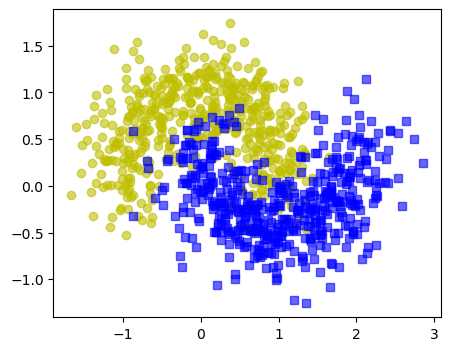

In [41]:
plt.figure(figsize=(5, 4))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', alpha=0.6)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', alpha=0.6)

### 投票策略：软投票和硬投票
- 硬投票：直接用类别值，少数服从多数
- 软投票：各自分类器的概率值进行加权平均

#### 硬投票实验

In [42]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(random_state=42)

vote_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('scv', svc_clf)], voting='hard')

vote_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('scv', SVC(random_state=42))])

In [43]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svc_clf, vote_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.852
RandomForestClassifier 0.912
SVC 0.916
VotingClassifier 0.908


#### 软投票实验
- 软投票，要求必须各个分类器都能得出**概率值**
- SVC需要加上参数`probability=True`才能得到概率值，不然只有结果

In [44]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(probability=True, random_state=42)

vote_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('scv', svc_clf)], voting='soft')

vote_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('scv', SVC(probability=True, random_state=42))],
                 voting='soft')

In [45]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svc_clf, vote_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.852
RandomForestClassifier 0.912
SVC 0.916
VotingClassifier 0.916


### Bagging策略
- 首先对数据集进行多次采样，保证每次得到的采样数据都是不同的
- 分别训练多个模型，例如树模型
- 预测时需得到所有模型结果再进行集成

In [67]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            max_samples=100, 
                            bootstrap=True, 
                            n_jobs=-1,
                            random_state=7,
                           )
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

accuracy_score(y_test, y_pred)

0.912

In [51]:
tree_clf = DecisionTreeClassifier(random_state=7)
tree_clf.fit(x_train, y_train)
y_pred_tree = tree_clf.predict(x_test)
accuracy_score(y_test, y_pred_tree)

0.888

### 决策边界
- 集成与传统方法对比


In [87]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-2, 3, -1.5, 2], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_test = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_test).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.2)
    if contour:
        custom_cmap_2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap_2, alpha=alpha)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', alpha=0.1)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', alpha=0.1)
    plt.axis(axes)
    plt.xlabel('x1')
    plt.ylabel('x2')

Text(0.5, 1.0, 'decision tree with bagging')

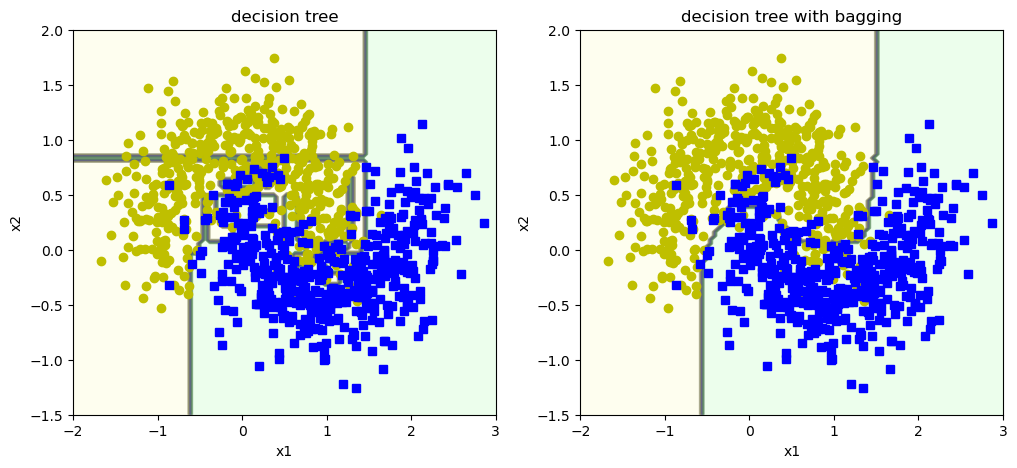

In [65]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title('decision tree')
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title('decision tree with bagging')

### OOB策略（Out Of Bag）
- 是随机森林和其他基于集成方法的模型中的一种技术，用来评估模型的性能，而不需要使用独立的验证集。
- 构建随机森林模型时，使用**Bootstrap采样**，由于是有放回采样，未被选择的样本就是所谓的袋外数据

In [68]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            max_samples=100, 
                            bootstrap=True, 
                            n_jobs=-1,
                            random_state=7,
                            oob_score=True,
                           )
bag_clf.fit(x_train, y_train)
bag_clf.oob_score_

0.9093333333333333

In [69]:
y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.912

In [70]:
bag_clf.oob_decision_function_

array([[0.39130435, 0.60869565],
       [0.53514739, 0.46485261],
       [1.        , 0.        ],
       ...,
       [0.96296296, 0.03703704],
       [0.74831461, 0.25168539],
       [0.05164319, 0.94835681]])

### 随机森林

In [71]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

RandomForestClassifier()

#### 特征重要性：
sklearn中看每个特征的**平均深度**

In [72]:
from sklearn.datasets import load_iris

iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(iris['data'], iris['target'])
for name,score in zip(iris['feature_names'], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10784163952508344
sepal width (cm) 0.022306999782894302
petal length (cm) 0.4358250845031764
petal width (cm) 0.4340262761888459


#### Mnist中哪些特征比较重要？
- 热度图
- `fetch_openml`用于从OpenML平台上获取公开的机器学习数据集集

In [73]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
rf_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [74]:
rf_clf.feature_importances_.shape

(784,)

[Text(1, 0.0, 'Not important'), Text(1, 0.00884894605675152, 'Very important')]

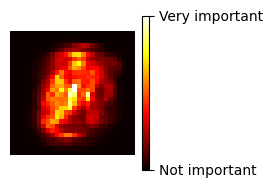

In [84]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap=matplotlib.cm.hot)
    plt.axis('off')

plot_digit(rf_clf.feature_importances_)
char = plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
char.ax.set_yticklabels(['Not important','Very important'])

## Boosting-提升策略

### AdaBoost
出错的数据，再下次要额外重视
- 以SVM分类器为例来演示AdaBoost的基本策略

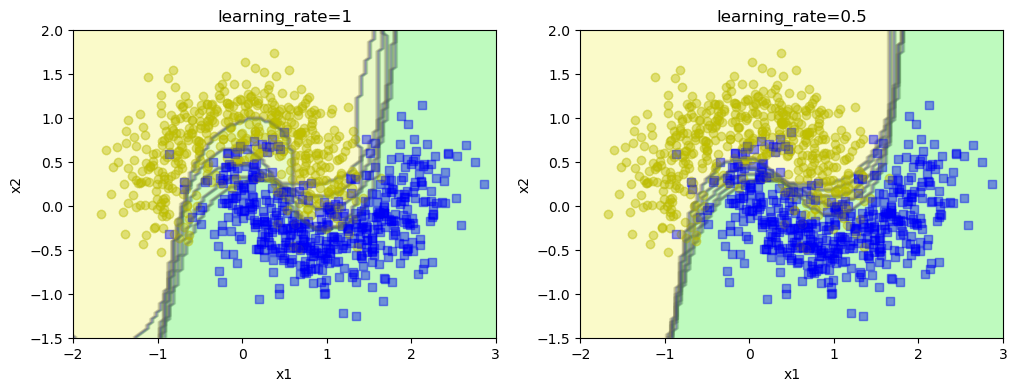

In [88]:
m = len(x_train)

plt.figure(figsize=(12, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.05, random_state=7)
        svm_clf.fit(x_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(x_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
    plt.title('learning_rate={}'.format(learning_rate))
plt.show()

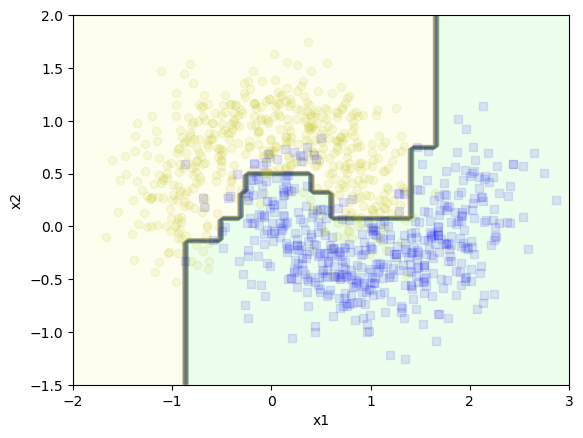

In [91]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                   n_estimators=200,
                   learning_rate=0.5,
                   algorithm='SAMME',
                   random_state=7,
                  )
ada_clf.fit(x_train, y_train)
plot_decision_boundary(ada_clf, X, y)

#### Gradient Boosting
- `from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegression`
- Xgboost
- LightGBM


- 如下是一个基本的思想过程
- y的生成过程：需要是一个**一维数组**，不然可能会被模型认为是多输出回归

In [41]:
import numpy as np

np.random.seed(7)

X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

# y = 3 * X ** 2 + 0.05 * np.random.randn(100, 1)
# y = y.ravel()

print(X.shape, y.shape)

(100, 1) (100,)


In [42]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_1 = DecisionTreeRegressor(max_depth=2)
tree_reg_1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [43]:
y2 = y - tree_reg_1.predict(X)
tree_reg_2 = DecisionTreeRegressor(max_depth=2)
tree_reg_2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [44]:
y3 = y2 - tree_reg_2.predict(X)
tree_reg_3 = DecisionTreeRegressor(max_depth=2)
tree_reg_3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [45]:
x_test = np.array([[0.8]])
y_pred = sum(tree.predict(x_test) for tree in (tree_reg_1, tree_reg_2, tree_reg_3))
print(y_pred)

[0.58891486]


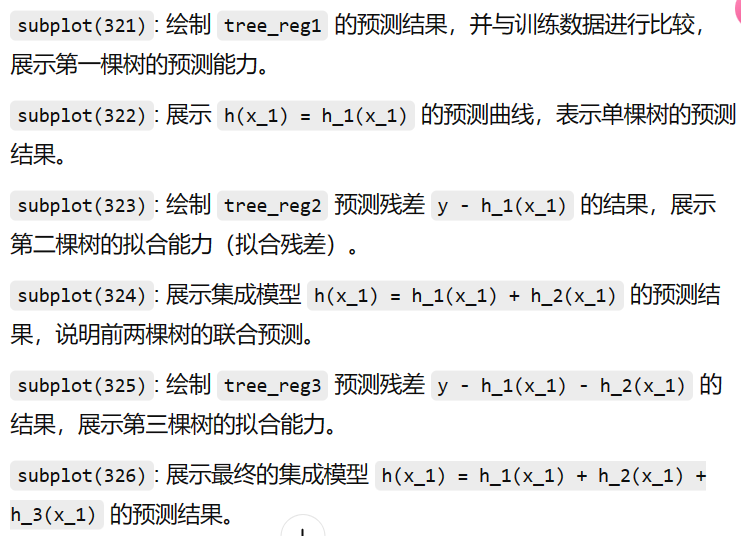

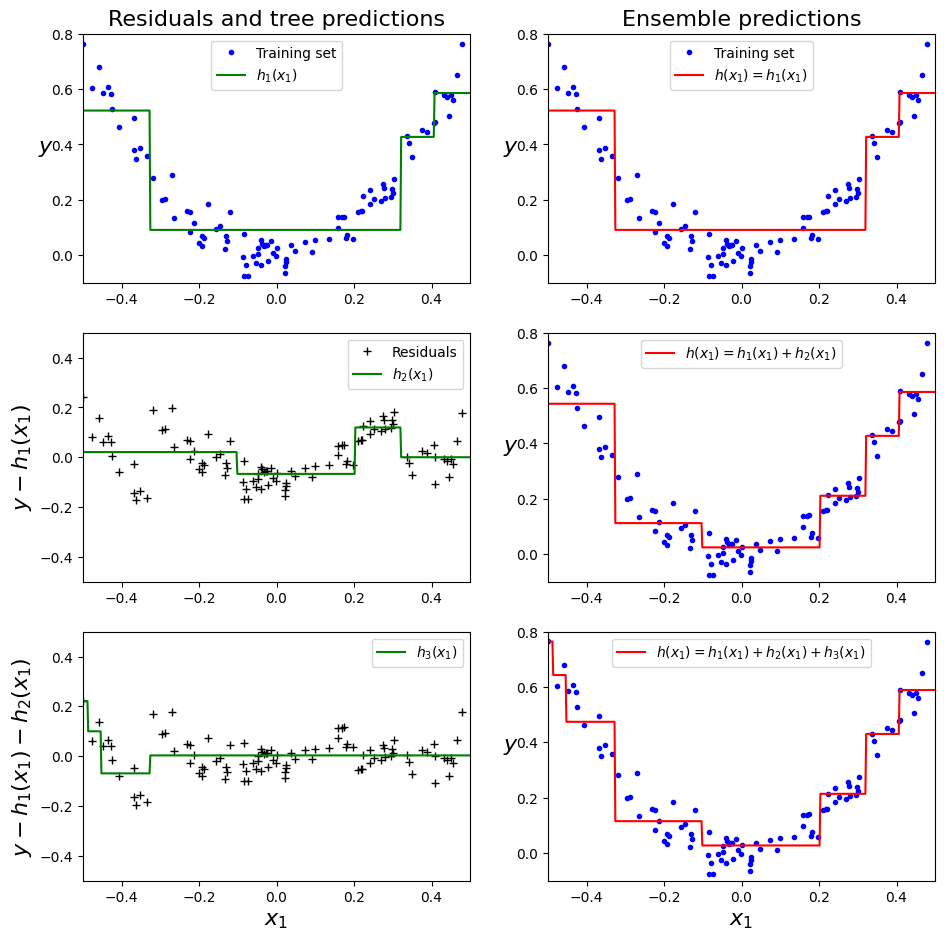

In [88]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = sum(regressor.predict(x1) for regressor in regressors)
    plt.plot(X, y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, label=label)
    if label or data_label:
        plt.legend()
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg_2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg_1, tree_reg_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg_3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg_1, tree_reg_2, tree_reg_3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg_1 = GradientBoostingRegressor(max_depth=2, 
                          n_estimators=3,
                          learning_rate=1.0,
                          random_state=7,
                         )
gb_reg_1.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=7)

In [58]:
gb_reg_2 = GradientBoostingRegressor(max_depth=2, 
                          n_estimators=3,
                          learning_rate=0.1,
                          random_state=7,
                         )
gb_reg_2.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=7)

In [59]:
gb_reg_3 = GradientBoostingRegressor(max_depth=2, 
                          n_estimators=200,
                          learning_rate=0.1,
                          random_state=7,
                         )
gb_reg_3.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=7)

第一组对比实验

Text(0.5, 1.0, 'leanring_rate=0.1, n_estimators=3')

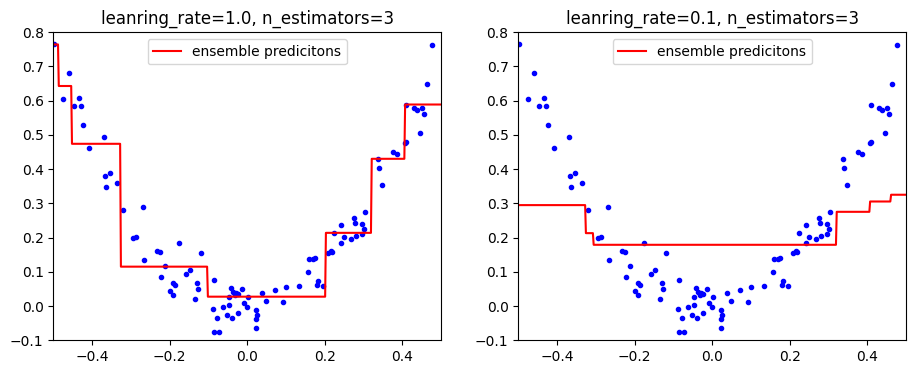

In [64]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gb_reg_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='ensemble predicitons')
plt.title('leanring_rate={}, n_estimators={}'.format(gb_reg_1.learning_rate, gb_reg_1.n_estimators))
plt.subplot(122)
plot_predictions([gb_reg_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='ensemble predicitons')
plt.title('leanring_rate={}, n_estimators={}'.format(gb_reg_2.learning_rate, gb_reg_2.n_estimators))

第二组对比实验

Text(0.5, 1.0, 'leanring_rate=0.1, n_estimators=200')

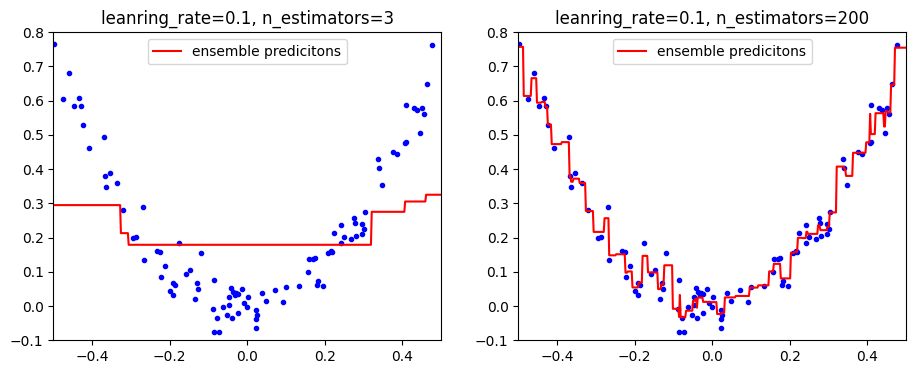

In [65]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gb_reg_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='ensemble predicitons')
plt.title('leanring_rate={}, n_estimators={}'.format(gb_reg_2.learning_rate, gb_reg_2.n_estimators))
plt.subplot(122)
plot_predictions([gb_reg_3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='ensemble predicitons')
plt.title('leanring_rate={}, n_estimators={}'.format(gb_reg_3.learning_rate, gb_reg_3.n_estimators))

### 提前停止策略
- 属性：`.staged_predict`——可以逐步预测+可用于**早停**；且返回值是一个形状为(n_samples,)的数组

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_val, y_train, y_val = train_test_split(X, y, random_state=10)
gb_reg = GradientBoostingRegressor(max_depth=2, 
                          n_estimators=120,
                          random_state=7,
                         )
gb_reg.fit(x_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gb_reg.staged_predict(x_val)]
best_n_estimator = np.argmin(errors)

In [80]:
gb_reg_best = GradientBoostingRegressor(max_depth=2, 
                          n_estimators=best_n_estimator,
                          random_state=7,
                         )
gb_reg_best.fit(x_train, y_train)

min_error = np.min(errors)
print(min_error)

0.0028779216491771303


#### 展示

Text(0.5, 1.0, 'best model 38')

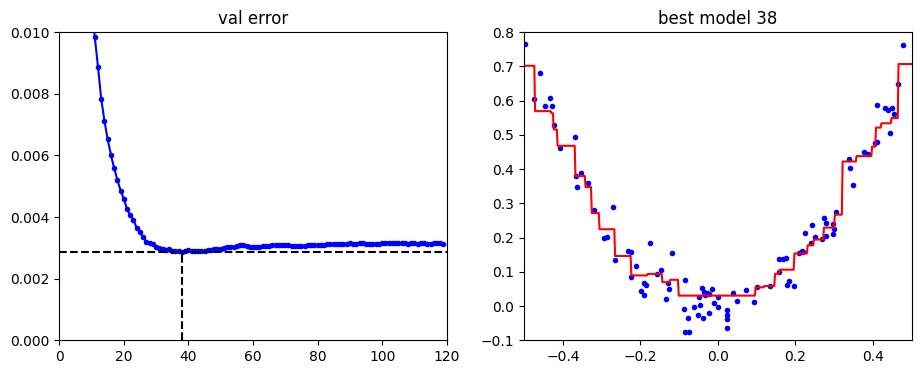

In [89]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(np.arange(0, 120), errors, 'b.-') # np.arange(0, 120), 完全可以删除
plt.plot([best_n_estimator, best_n_estimator], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.axis([0, 120, 0, 0.01])
plt.title('val error')

plt.subplot(122)
plot_predictions([gb_reg_best], X ,y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title('best model {}'.format(best_n_estimator))

#### 如何实施 早停
- `warm_start`——When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just erase the previous solution. 

In [92]:
gb_reg = GradientBoostingRegressor(max_depth=2, 
                                 #  n_estimators=120,
                                   random_state=7,
                                   warm_start=True,
                                  )
min_val_error = float('inf')
# error_going_count = 0

for n_estimators in range(1, 120):
    gb_reg.n_estimators = n_estimators
    gb_reg.fit(x_train, y_train)
    y_pred = gb_reg.predict(x_val)
    val_errors = mean_squared_error(y_val, y_pred)
    if val_errors < min_val_error:
        min_val_error = val_errors
        error_going_count = 0
    else:
        error_going_count += 1
        if error_going_count == 5:
            break  

In [93]:
print(gb_reg.n_estimators)

44


### Stacking（堆叠集成）
- 分为两个阶段，第一个阶段用不同的分类器分别得到各自的结果，再通过第二阶段，把第一阶段的结果当做输入
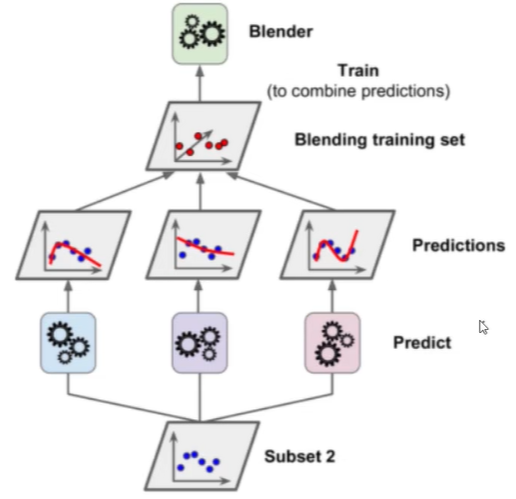

#### 注：
- 第一次划分：将原始数据划分为训练集+验证集 和 测试集。测试集用于最终模型的评估，不用于训练
- 第二次划分：从训练集+验证集中进一步划分出真正的训练集和验证集。训练集用于训练模型，验证集用于在训练过程中评估模型的性能

In [97]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1,  parser='auto')

x_train_val, x_test, y_train_val, y_test = train_test_split(mnist.data, 
                                                  mnist.target, 
                                                  test_size=10000, 
                                                  random_state=7
                                                 )
x_train, x_val, y_train, y_val = train_test_split(x_train_val, 
                                                  y_train_val, 
                                                  test_size=10000, 
                                                  random_state=7
                                                 )

#### 第一阶段

In [98]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [100]:
random_forest_clf = RandomForestClassifier(random_state=7)
extra_trees_clf = ExtraTreesClassifier(random_state=7)
svm_clf = LinearSVC(random_state=7)
mlp_clf = MLPClassifier(random_state=7)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
# estimator.fit(x_train, y_train) for estimator in estimators 这是错误的写法

for estimator in estimators:
    estimator.fit(x_train, y_train)

D:\envs\fxr_env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\envs\fxr_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [102]:
x_val_pred = np.empty((len(x_val), len(estimators)), dtype=float)

for index, estimator in enumerate(estimators):
    x_val_pred[:, index] = estimator.predict(x_val)

print(x_val_pred)

[[0. 0. 0. 0.]
 [2. 2. 2. 2.]
 [7. 7. 9. 7.]
 ...
 [4. 4. 4. 4.]
 [6. 6. 6. 6.]
 [0. 0. 0. 0.]]


#### 第二阶段

In [104]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=7)
rnd_forest_blender.fit(x_val_pred, y_val)
rnd_forest_blender.oob_score_

0.9711